<a href="https://colab.research.google.com/github/AnastasiaDvoynova/GameMarketAnalysis/blob/main/Game_Market_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Описание проекта


Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Доступны данные до 2016 года. Представим, что сейчас декабрь 2016 г. и спланируем кампанию на 2017-й. 

# Подготовка данных к анализу


Откроем файл с данными и изучим общую информацию.

## Описание данных games.csv
Name — название игры

Platform — платформа

Year_of_Release — год выпуска

Genre — жанр игры

NA_sales — продажи в Северной Америке (миллионы долларов)

EU_sales — продажи в Европе (миллионы долларов)

JP_sales — продажи в Японии (миллионы долларов)

Other_sales — продажи в других странах (миллионы долларов)

Critic_Score — оценка критиков (от 0 до 100)

User_Score — оценка пользователей (от 0 до 10)

Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board)

In [1]:
import pandas as pd
import numpy

file_obj = pd.read_csv('https://raw.githubusercontent.com/AnastasiaDvoynova/GameMarketAnalysis/main/Data/games.csv')
file_obj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [2]:
new_columns = []
#создаем новый список для заголовков

for column in file_obj.columns:
    new_columns.append(column.lower())
print(new_columns)
#в цикле проходимся по каждому заголовку, меняем его регистр на нижний и записываем в новый список

file_obj.set_axis(new_columns, axis = 'columns', inplace = True)
#заменяем названия столбцов на новые

['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating']


In [3]:
new_columns = []
# создаем новый список для заголовков
for column in file_obj.columns:
    new_columns.append(column.lower())
print(new_columns)
# в цикле проходимся по каждому заголовку, меняем его регистр на нижний
# и записываем в новый список
file_obj.set_axis(new_columns, axis = 'columns', inplace = True)
# заменяем названия столбцов на новые

['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating']


Произойдет скачивание необходимых пакетов для построения отчета

%load_ext autoreload

%autoreload 2

import sys

!{sys.executable} -m pip install -U pandas-profiling[notebook]

!jupyter nbextension enable --py widgetsnbextension

Посмотрим на отчёт по данным. 



1.   Отсутствующие значения занимают 12.1% от всего датасета.
2.   В данных нет дубликатов.
3.   В 269 записях отсутсуют данные о годе выпуска игры. Некоторые пропуски полностью случайны, эти данные можно восстановить как из названий некоторых игр, так и из источников интернета.
4.   В датасете большая представленноть игр жанра Action, Sports, Misc, Role-Playing, Shooter.
5.   В данных столбца critic_score и user_score отсутсвует 51,3% и 40,1% значений соотвественно. Достаточно большой процент отсутствующих значений, поэтому заполнение **nan** медианным или средним значением может вызвать неправильное отражение данных или их исказит. Можно предположить, что значения отсутвуют либо по случайности, либо потому, что игра была совсем непопулярна, поэтому рейтинга критиков и пользователей у нее нет. 
6.   В столбце user_score находится 2424 значения «tbd» или «to be determined», то есть будут определены. Эти значения неслучайные, так как либо значение калибруется или изменяется, либо данные о рейтинге появятся позже. Переведем эти значения в nan.

импортируем библиотеку для создания отчета

import pandas_profiling

from pandas_profiling.utils.cache import cache_file

report = file_obj.profile_report(
    sort="None", html={"style": {"full_width": True}}, progress_bar=False)

report

In [4]:
file_obj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Можно заметить, что **year_of_realease** стоит перевести в тип **int** для наглядности, прежде заменив значения NaN на 0, чтобы не возникло ошибки. А **user_score** перевести в тип **float**, так как оценка чаще всего вещественное число.

In [5]:
NaN_error = 0 
file_obj['year_of_release'] = file_obj['year_of_release'].fillna(NaN_error).astype(int)
file_obj['user_score'] = pd.to_numeric(file_obj['user_score'], errors='coerce')
file_obj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16715 non-null  int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец global_sales.

In [6]:
global_sales = file_obj['na_sales'] + file_obj['eu_sales'] + \
                  file_obj['jp_sales'] + file_obj['other_sales']
file_obj.insert(loc=8, column='global_sales', value=global_sales)

# Проведение исследовательского анализа данных

In [7]:
# импортируем необходимые библиотеки для визуализации данных
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objects as go

## Посмотрим, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

In [8]:
year_game_count = file_obj[file_obj['year_of_release'] != 0].groupby(['year_of_release'])['name'].count()

#построим столбчатую диаграмму
fig = go.Figure(
    data=[go.Bar(y = year_game_count, x = year_game_count.index)],
    layout_title_text="Количество релизов игр по годам"
)
fig.show()

*Вывод по графику*:

Количество выпущенных игр на игровые приставки и ПК показывало постепенный рост с 1990 по 2008 год.

С 2009 года видно сильное снижение. Это можно объяснить развитием рынка мобильных игр и игр для планшетов.
Совершенно незначительный рост релизов игр присутствует с 2013 по 2015 года. 

Согласно оценкам J’son & Partners, в 2013 году большая доля рынка приходилась на игровой ПК-рынок (почти 40%), и 37% занимал сегмент консолей, то в 2016 году самым крупным сегментом становится сегмент мобильных игр, генерируя выручку 36,9 млрд долларов, что соответствует 37% всего объема мирового рынка игр. То есть в 2016 году доходы в мобильном сегменте впервые превысили доходы от сегмента игр на персональных компьютерах. За 2013-2016 гг. для смартфонов показатель роста CAGR составил 28.4%, а для планшетов — 26.9%.
Таким образом, в 2017 году динамика выпуска игр на игровые приставки и ПК скорее всего так же будет показывать снижение.

## Выберем платформы с наибольшими суммарными продажами и построим распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

In [9]:
top_platforms = file_obj.groupby('platform')[['global_sales']].sum()\
  .sort_values('global_sales', ascending=False).head(5)

top_5_platform = top_platforms.reset_index().rename_axis(None, axis=1)
print(top_5_platform)

  platform  global_sales
0      PS2       1255.77
1     X360        971.42
2      PS3        939.65
3      Wii        907.51
4       DS        806.12


Text(0, 0.5, 'Сумма продаж')

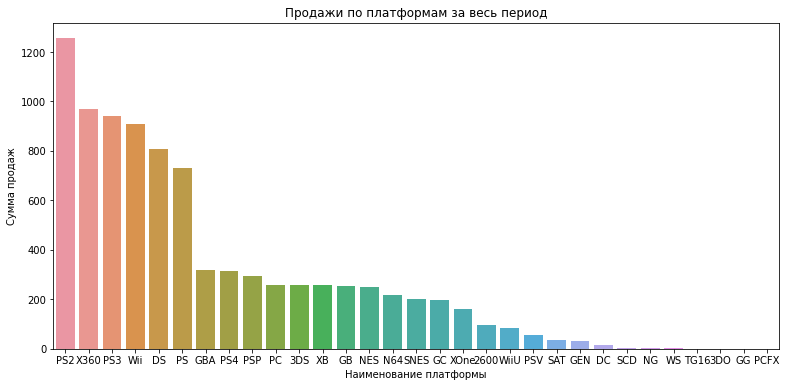

In [10]:
platform_sales = file_obj\
    .pivot_table(index='platform', values='global_sales', aggfunc='sum')\
    .sort_values(by='global_sales', ascending=False)

plt.figure(figsize=(13,6))
sns.barplot(x = platform_sales.index, y = platform_sales['global_sales'])
plt.title("Продажи по платформам за весь период")
plt.xlabel("Наименование платформы")
plt.ylabel("Сумма продаж")

За весь период самая прибыльная платформа: PS2, в топ-5 также входят платформы X360, PS3, Wii и DS 

### Те платформы, которые лидируют по продажам, растут или падают? Выберем несколько потенциально прибыльных платформ.

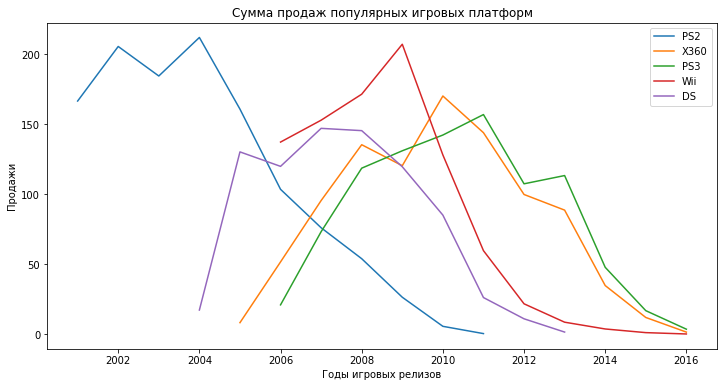

In [11]:
plt.figure(figsize=(12,6))
plt.title('Сумма продаж популярных игровых платформ')
plt.xlabel('Годы игровых релизов')
plt.ylabel('Продажи')
for i in list(top_5_platform['platform']):  
    platform_dynamisc = file_obj[(file_obj['platform'] == i) & (file_obj['year_of_release'] > 2000)]\
    .pivot_table(index='year_of_release', values='global_sales', aggfunc='sum')\
    .sort_values('year_of_release', ascending=False)
    
    sns.set_palette("Paired", 10)
    sns.lineplot(data=platform_dynamisc['global_sales'], label=i)
    plt.legend()

На графике можно заметить, что среднее время существование платфоромы 10 лет, пик продаж у платформ в наступает через 3-5 лет.

У платформы Wii в течение трех лет резко выросли продажи, однако последовало такое же резкое снижение.

### Построим график «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам.

['PS2' 'DS' 'PS3' 'Wii' 'X360']


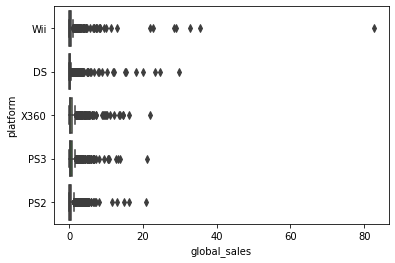

In [12]:
top_platforms = file_obj.platform.value_counts().sort_values(ascending = False).head(5).index.values
print(top_platforms)
sns.boxplot(y="platform", x="global_sales", data=file_obj[file_obj.platform.isin(top_platforms)], orient="h")

Заметим существенный выброс продаж на платформе Wii.
Отфильтруем данные, избавив от большинства выбросов. Посмотрим на данные, где глобальные продажи меньше 2 млн.

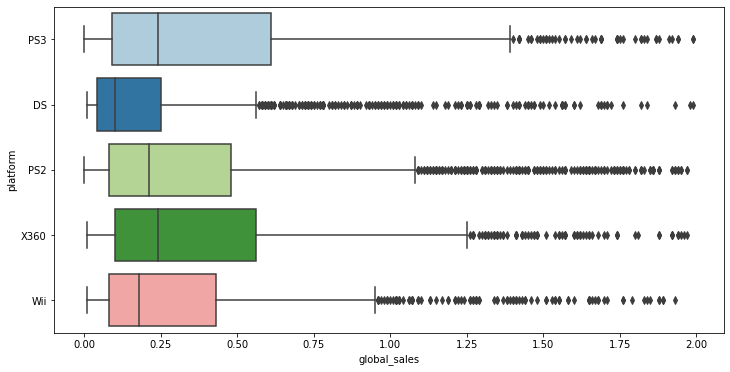

In [13]:
small_gsales = file_obj[file_obj['global_sales'] < 2]
plt.figure(figsize=(12,6))
sns.boxplot(y="platform", x="global_sales", data=small_gsales[small_gsales.platform.isin(top_platforms)], orient="h")

Наибольший межквартильный размах среди глобальных продаж у платформы PS3, на втором месте X360.
Медианы продаж двух этих платформы примерно одинаковы.
Наименьший размах среди продаж у платформы DS.

## Построим диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами.

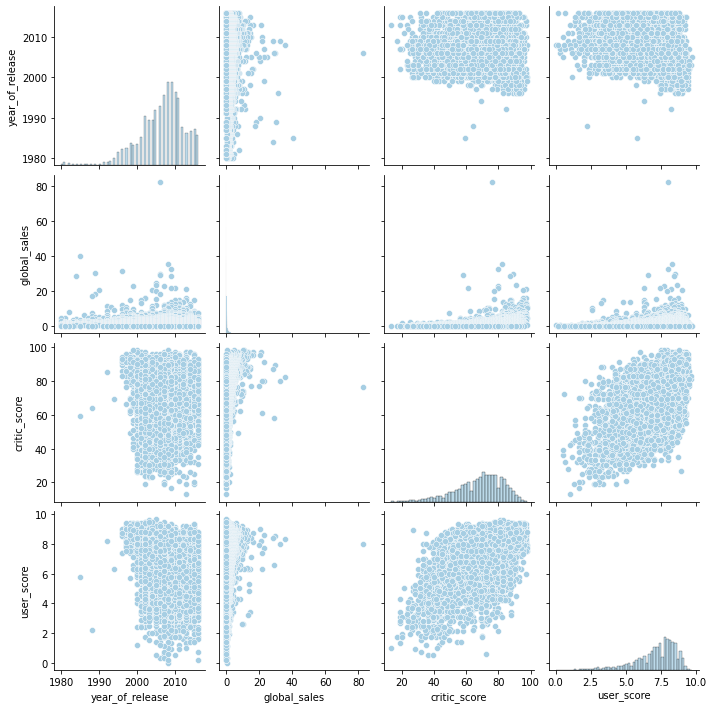

In [14]:
cols = ['year_of_release', 'genre', 'global_sales', 'critic_score', 'user_score', 'rating']
norm_year = file_obj[file_obj['year_of_release'] != 0]
sns_plot = sns.pairplot(norm_year[cols])

На диаграмме сразу можно заметить сильную прямую корреляцию между отзывами критиков и отзывами пользователей.
Но что с взамосвязью отзывов и продажами? Посчитаем корреляцию.

In [15]:
# Напишем функцию, которая будет считать корреляцию между отзывами
# и продажами на конкретной платформе
def correlation_platform_score(score, sales, platform):
    data = file_obj[file_obj['platform'] == platform]
    correlation = data[score].corr(data[sales])
    if 0.3 >= correlation >= 0.1:
        print('Корреляция между {} и {} на платформе {}'.format(score, sales, platform), ': Слабая')
    elif 0.5 >= correlation >= 0.3:
        print('Корреляция между {} и {} на платформе {}'.format(score, sales, platform), ': Умеренная')
    elif 0.7 >= correlation >= 0.5:
        print('Корреляция между {} и {} на платформе {}'.format(score, sales, platform), ': Высокая')
    elif 0.9 >= correlation >= 0.7:
        print('Корреляция между {} и {} на платформе {}'.format(score, sales, platform), ': Весьма высокая')
    elif 1 >= correlation >= 0.9:
        print('Корреляция между {} и {} на платформе {}'.format(score, sales, platform), ': Сильная')

# И выведем значения для топ-5 платформ
for i in list(top_5_platform['platform']):
    correlation_platform_score('user_score', 'global_sales', str(i))
    correlation_platform_score('critic_score', 'global_sales', str(i))
    print('\n')

Корреляция между user_score и global_sales на платформе PS2 : Слабая
Корреляция между critic_score и global_sales на платформе PS2 : Умеренная


Корреляция между user_score и global_sales на платформе X360 : Слабая
Корреляция между critic_score и global_sales на платформе X360 : Умеренная


Корреляция между user_score и global_sales на платформе PS3 : Слабая
Корреляция между critic_score и global_sales на платформе PS3 : Умеренная


Корреляция между user_score и global_sales на платформе Wii : Слабая
Корреляция между critic_score и global_sales на платформе Wii : Слабая


Корреляция между user_score и global_sales на платформе DS : Слабая
Корреляция между critic_score и global_sales на платформе DS : Слабая




Между отзывами пользователей и глобальными продажами на всех топ-5 платформах корреляция слабая, однако так нельзя сказать о об корреляции с отзывами критиков. 

Между отзывами критиков и глобальными продажами на топ-3 платформах (PS2, X360, PS3) корреляция умеренная.

## Посмотрим на общее распределение игр по жанрам.

Text(0, 0.5, 'Продажи')

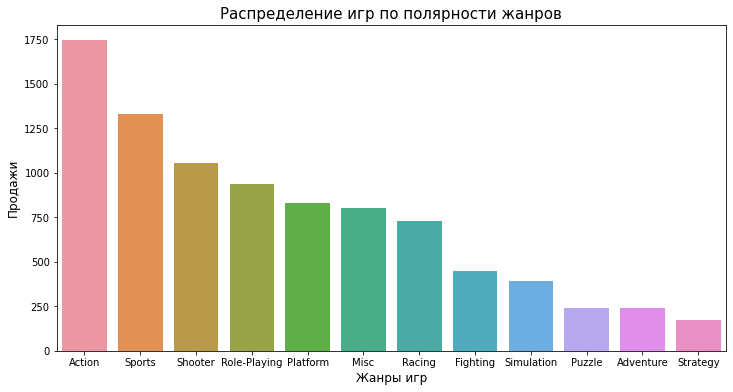

In [16]:
genre_distribution = file_obj\
  .pivot_table(index='genre', values='global_sales', aggfunc='sum')\
  .sort_values(by='global_sales', ascending=False)
genre_distribution = genre_distribution.reset_index().rename_axis(None, axis=1)

#построим столбчатую диаграмму
plt.figure(figsize=(12,6))
plt.title('Распределение игр по полярности жанров',fontsize=15)
sns.barplot(data=genre_distribution, x='genre', y='global_sales')
plt.xlabel('Жанры игр',fontsize=12)
plt.ylabel('Продажи',fontsize=12)

Самый прибыльный жанр - это **Action**.
В топ-5 самых прибыльных также входят: Sports, Shooter, Role-Playing и Platform

А жанры с самыми низкими продажами: Puzzle, Adventure, Strategy

# Составленим портрет пользователя каждого региона

In [17]:
# Напишем функцию, которая будет выбирать в сводную таблицу данные
# по необходимому объекту сравнения, в определенной стране с определенного года
# и выводить график
def country_preferences(country, year=1980):

    from_time = file_obj[file_obj['year_of_release'] >= year]
    for obj in ['platform', 'genre', 'rating']:
        if country == 'North America':
            sales = 'na_sales'
        elif country == 'Europe':
            sales = 'eu_sales'
        elif country == 'Japan':
            sales = 'jp_sales'
        else:
            sales = 'other_sales'
            
        country_preferences = from_time\
          .pivot_table(index= obj, values=sales, aggfunc='sum')\
          .sort_values(by=sales, ascending=False)\
          .head(5)
        country_preferences = country_preferences.reset_index().rename_axis(None, axis=1)

        plt.figure(figsize=(7,4))
        plt.title('Preferred {} in {} from {}'.format(obj, country, year),fontsize=15)
        sns.set_palette("rocket")
        sns.barplot(data=country_preferences, x=obj, y=sales)
        plt.xlabel(str(obj),fontsize=12)
        plt.ylabel(str(sales),fontsize=12) 

## Посмотрим на предпочитаемые платформы, жанры и рейтинги игр в Северной Америке за весь период и с 2015 года.

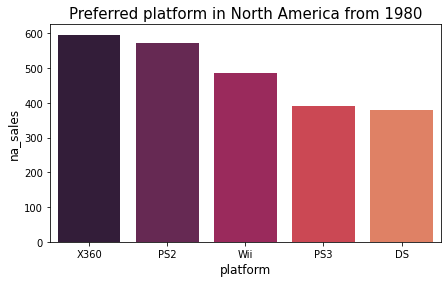

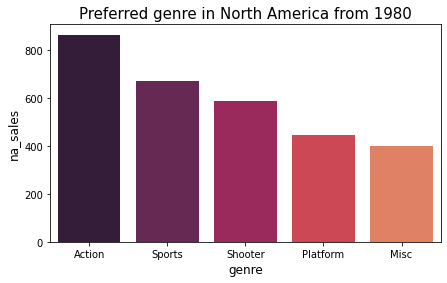

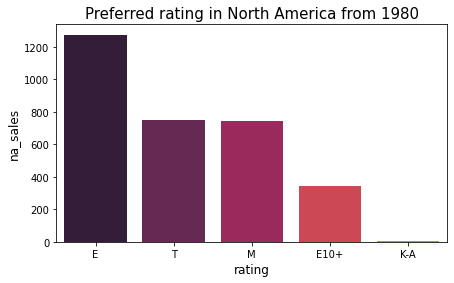

In [18]:
country_preferences('North America') 

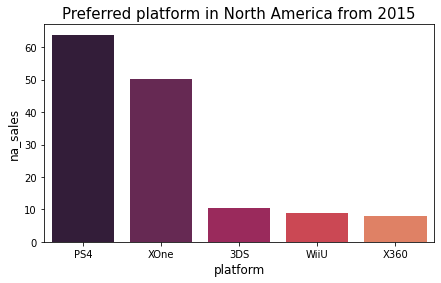

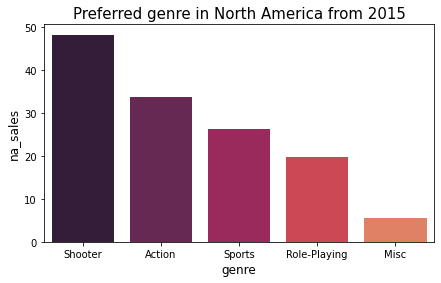

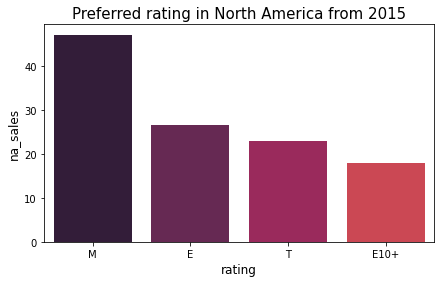

In [19]:
country_preferences('North America', 2015)

### Вывод по графикам:

**За весь период**:
*Самые популярные игровые платформы в Северной Америке*: XBOX, PS2, WII, PS3, DS.

*Топ-5 жанров*: Action, Sports, Shooter, Platform, Misc.

*Предпочитаемые рейтинги*: E (для всех) - наибольшее количество, T (для подростов) и M (для взрослых) примерно одинаковое количество.

**За период 2015-2016**:
С 2015 по 2016 год интерес пользователей меняется:

*Топ игровых приставок выглядит таким образом*: PS4, Xone, 3DS

*Топ жанров игр*: Shooter, Action, Sports. За последний год американские пользователи больше предпочитали жанр Shooter жанру Action.

*Топ рейтингов игр*: M (для взрослых) - наибольшее количество, E (для всех) и T (для подростков) За последний год американские пользователи больше предпочитали рейтинг игр М (для взрослых) рейтингу E (для всех).

## Посмотрим на предпочитаемые платформы, жанры и рейтинги игр в Европе за весь период и с 2015 года.

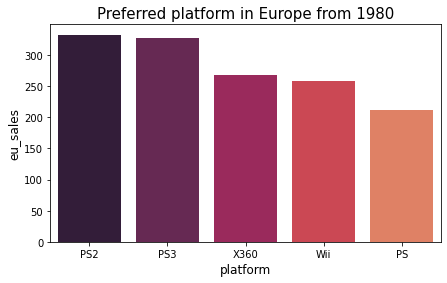

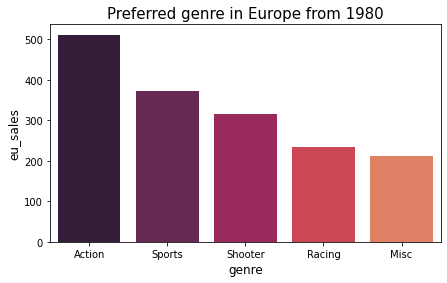

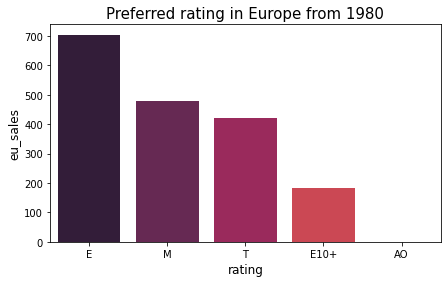

In [20]:
country_preferences('Europe') 

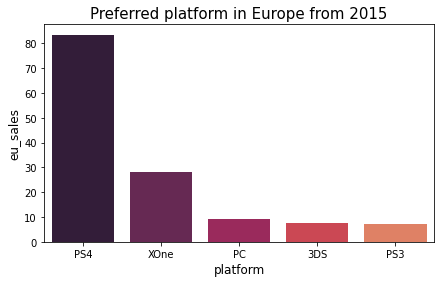

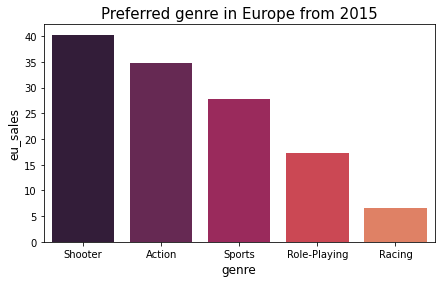

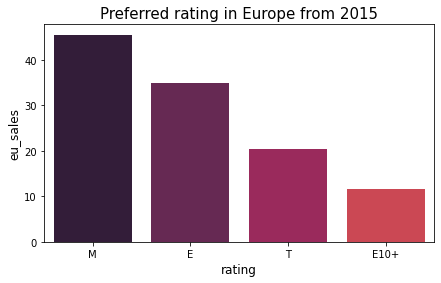

In [21]:
country_preferences('Europe', 2015) 

### Вывод по графикам:

**За весь период**:
*Самые популярные игровые платформы в Европе*: PS2, PS3, X360, WII, DS.

*Топ-5 жанров*: Action, Sports, Shooter, Racing, Misc.

*Предпочитаемые рейтинги*: E (для всех) - наибольшее количество, M (для взрослых) и чуть меньше T (для подростов).

**За период 2015-2016**:
С 2015 по 2016 год предпочтение пользователей выглядит таким образом:

*Топ игровых приставок* : PS4, Xone, PC

*Топ жанров игр*: Shooter, Sports, Action. 
За последние годы европейцы как и американские пользователи больше предпочитали жанр Shooter. Жанр Action опустился на 3 место.

*Топ рейтингов игр*: M (для взрослых) - наибольшее количество, E (для всех) и T (для подростков). 
За последние годы европейцы больше предпочитали рейтинг игр М (для взрослых) рейтингу E (для всех).

## Посмотрим на предпочитаемые платформы, жанры и рейтинги игр в Японии за весь период и с 2015 года.

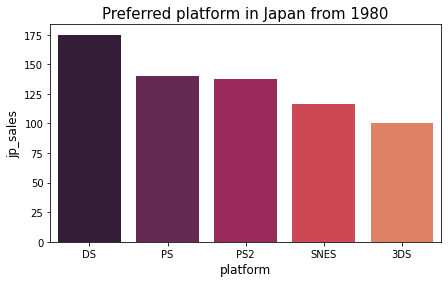

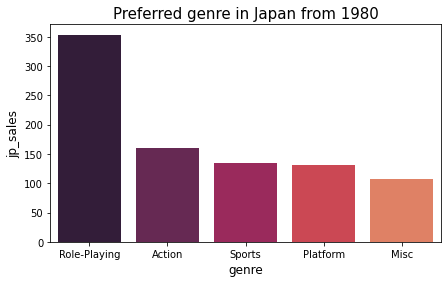

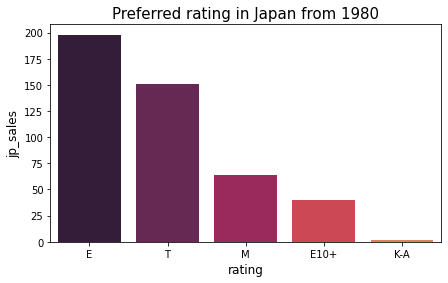

In [22]:
country_preferences('Japan')

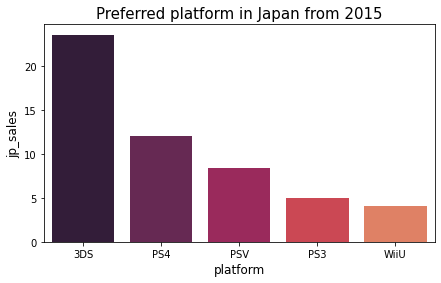

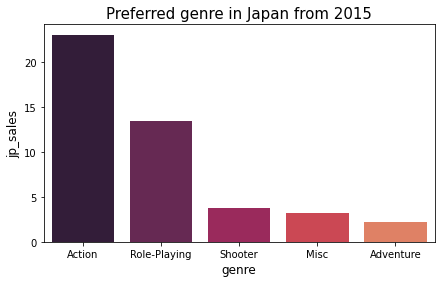

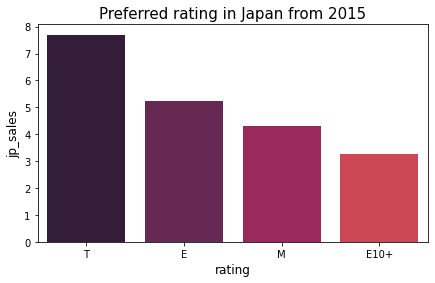

In [23]:
country_preferences('Japan', 2015)

### Вывод по графикам:

**За весь период**:

*Самые популярные игровые платформы в Японии*: DS, PS, PS2, SNES, 3DS.

*Топ-5 жанров*: Role-Playing, Action, Sports, Platform, Misc.

*Предпочитаемые рейтинги*: E (для всех) - наибольшее количество, T (для подростов), M (для взрослых).

**За период 2015-2016**:
С 2015 по 2016 год предпочтение пользователей выглядит таким образом:

*Топ игровых приставок* : 3DS, PS4, PSV.

*Топ жанров игр*: Action, Role-playing, Adventure За последние годы японские пользователи больше предпочитали жанр Action. Жанр Role-playing опустился на 2 место.

*Топ рейтингов игр*: T (для подростков) - наибольшее количество, E (для всех) и M (для взрослых). За последние годы японцы больше предпочитали рейтинг игр T (для подростков) рейтингу E (для всех).

Заметим, что в последние 2 года у пользователей всех трех стран преобладает интерес к платформе PS4, у пользователей Америки и Европы появляется интерес к XOne, а у пользователей Америки и Японии - к 3DS. 

Построим линейную диаграмму по всем этим платформам, чтобы посмотреть их динамику.

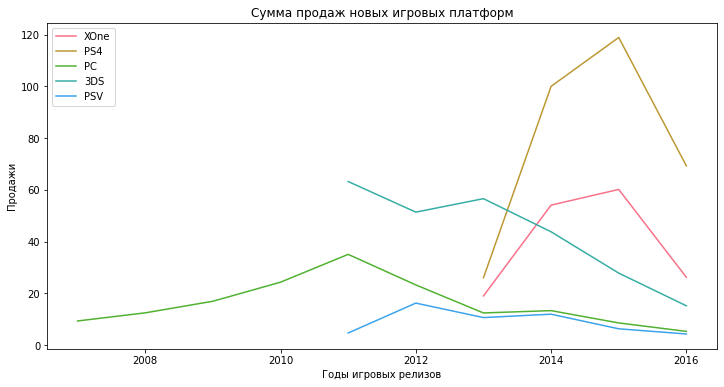

In [35]:
plt.figure(figsize=(12,6))
plt.title('Сумма продаж новых игровых платформ')
plt.xlabel('Годы игровых релизов')
plt.ylabel('Продажи')
sns.set_palette("husl")

for i in ['XOne', 'PS4', 'PC', '3DS', 'PSV']:  
    platform_dynamisc = file_obj[(file_obj['platform'] == i) & (file_obj['year_of_release'] > 2006)]\
    .pivot_table(index='year_of_release', values='global_sales', aggfunc='sum')\
    .sort_values('year_of_release', ascending=False)
    
    sns.lineplot(data=platform_dynamisc['global_sales'], label=i)
    plt.legend()

Самая прибыльная из этих пяти платформа PS4.
PS4 и XOne появились в 2013 году и показывали рост продаж (у PS4 резкий рост), но после 2015 продажи начали снижаться. 
Однако, в течение 2-х следующих лет у этих двух платформ продажи скорее всего пойдут вверх.
Платформа 3DS в 2011 году показала хорошие продажи, однако после продажи начали снижаться.

# Проведение исследования статистических показателей

Как изменяется пользовательский рейтинг и рейтинг критиков в различных жанрах?
Построим диаграмму boxplot с разбивкой по жанрам игр.

In [25]:
# диаграмма оценок критиков
data = []
for genre in file_obj.genre.unique():
    data.append(
        go.Box(y=file_obj[file_obj.genre==genre].critic_score, name=genre)
    )
# визуализируем данные
iplot(data, show_link = False)

In [26]:
# диаграмма оценок отзывов
data = []
for genre in file_obj.genre.unique():
    data.append(
        go.Box(y=file_obj[file_obj.genre==genre].user_score, name=genre)
    )
# визуализируем данные
iplot(data, show_link = False)

Заметим, что межквартильный размах оценок критиков больше, чем у оценок пользователей, а выбросов минимальных значений меньше.
Медиана оценок критиков у всех жарков находится достаточно высоко, минимальная 66, это больше половины
Медиана у оценок пользователей тоже достаточно высокая, минимальная 7.1

Посчитаем среднее, медиану, дисперсию и стандартное отклонение у топ-5 жанров и построим распределения.

In [27]:
import numpy as np
top_5_genres = genre_distribution.head(5)
for genre in list(top_5_genres.genre):
    genre_data = file_obj[file_obj['genre']==genre]['user_score']
    print('Среднее значение', genre,':',  genre_data.mean())
    print('Медиана', genre,':',  genre_data.median(),)
    print('Дисперсия', genre,':', np.var(genre_data))
    print('Стандартное отклонение', genre,':', np.std(genre_data),  '\n')

Среднее значение Action : 7.054043715846988
Медиана Action : 7.4
Дисперсия Action : 2.030636653826616
Стандартное отклонение Action : 1.4250040890561038 

Среднее значение Sports : 6.961196736174073
Медиана Sports : 7.4
Дисперсия Sports : 2.5941606711770206
Стандартное отклонение Sports : 1.610639832854329 

Среднее значение Shooter : 7.041883116883125
Медиана Shooter : 7.4
Дисперсия Shooter : 2.3020877958621497
Стандартное отклонение Shooter : 1.5172632585883539 

Среднее значение Role-Playing : 7.619515477792736
Медиана Role-Playing : 7.8
Дисперсия Role-Playing : 1.1836433722368822
Стандартное отклонение Role-Playing : 1.0879537546407394 

Среднее значение Platform : 7.3014018691588785
Медиана Platform : 7.7
Дисперсия Platform : 2.2856989693423015
Стандартное отклонение Platform : 1.511852826614516 



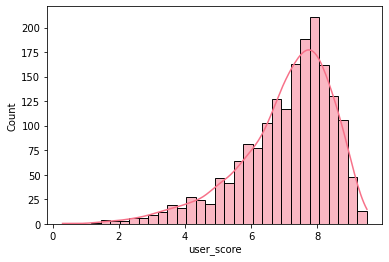

In [28]:
action_genre = file_obj[file_obj['genre']== 'Action']['user_score']
sns.histplot(action_genre, kde = True)

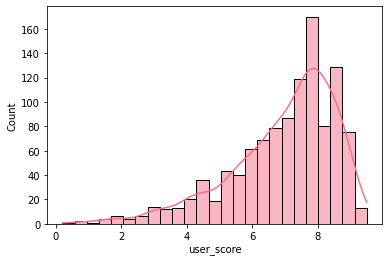

In [29]:
action_genre = file_obj[file_obj['genre']== 'Sports']['user_score']
sns.histplot(action_genre, kde = True)

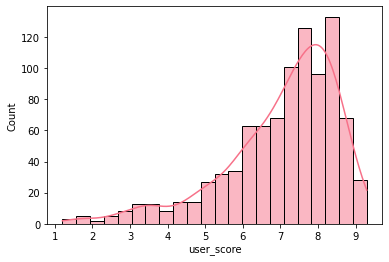

In [30]:
action_genre = file_obj[file_obj['genre']== 'Shooter']['user_score']
sns.histplot(action_genre, kde = True)

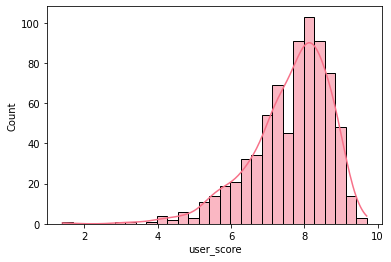

In [31]:
action_genre = file_obj[file_obj['genre']== 'Role-Playing']['user_score']
sns.histplot(action_genre, kde = True)

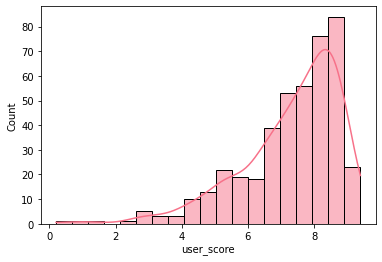

In [32]:
action_genre = file_obj[file_obj['genre']== 'Platform']['user_score']
sns.histplot(action_genre, kde = True)

Все распределения напоминают внешне нормальное распредление, скошенное вправо.

# Проверка гипотез

Проверим две гипотезы:
Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные.

**Гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые**

Нулевая гипотеза H₀: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

Альтернативная гипотеза H₁: Средние пользовательские рейтинги платформ Xbox One и PC различаются

In [33]:
from scipy import stats as st

#так как платформа PC появилась примерно с 2006 года, отфильтруем по этому значению

xone_data = (file_obj[(file_obj['platform']=='XOne') & (file_obj['year_of_release'] > 2006)]['user_score'])
pc_data = (file_obj[(file_obj['platform']=='PC') & (file_obj['year_of_release'] > 2006)]['user_score'])

print(xone_data.mean())
print(pc_data.mean())

#так как средние значения довольно близки возмьмем альфа раное 1%

alpha = 0.01  # критический уровень статистической значимости

results = st.ttest_ind(xone_data.dropna(), pc_data.dropna(), equal_var=False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

6.52142857142857
6.765499124343266
p-значение:  0.04401892858926169
Не получилось отвергнуть нулевую гипотезу


Нулевая гипотеза H₀: Средние пользовательские рейтинги жанров Action и Sports одинаковые

Альтернативная гипотеза H₁: Средние пользовательские рейтинги жанров Action и Sports различаются

In [34]:
action_data = file_obj[(file_obj['genre']=='Action') & (file_obj['year_of_release']>=2006)]['user_score']
sports_data = file_obj[(file_obj['genre']=='Sports') & (file_obj['year_of_release']>=2006)]['user_score']

action_data.mean()
sports_data.mean()

alpha = .01

results = st.ttest_ind(action_data.dropna(), sports_data.dropna(), equal_var=False)

print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 5.319061853268226e-10
Отвергаем нулевую гипотезу


Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
Мы не можем отверкнуть эту гипотезу

Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные.
Мы не можем отвергнуть эту гипотезу

# Общий вывод

1. Была проведена подготовка данных к анализу

2. В ходе исследовательского анализа была проанализирована динамика выхода игр, причины спада. 
Были выявлены самые популярные платформы за весь период. 
Была выявлена средняя продолжительность нахождения платформы на рынке и среднее время наступления пика продаж. 
Проведя анализ оценок пользователей и критиков, мы выявили умеренную коорреляцию между отзывами критиков и продажами топ-3 платформ, однако не можем утверждать, что чем выше отзыв критиков, тем больше продажи. 
Были составлены портреты каждого пользователя за весь период и за последние два года. Заметили изменяющийся интерес к платформам и жанрам игр.

3. Были проверены две гипотезы и сделаны выводы

Исходя из проведенного анализа можно сделать вывод, что Sony Playstation 4 в течение следующих лет будет продаваться больше всех остальных платформ, на втором месте будет ХOne. Пользователи Японии однако пока будут отдавать предпочтение 3DS и PS4.
Для пользователей Америки и Европы самым прибыльным будет жанр Shooter с рейтингом "от 17 и выше" (для взрослых), а японских пользователей - жанр Action c жанром T (для подростков)